# Building and Optimizing a CNN

In this assignment, you will design, implement, and optimize a Convolutional Neural Network (CNN) using PyTorch to classify images from the CIFAR-10 dataset. This will involve advanced preprocessing techniques, sophisticated model architectures, hyperparameter tuning, ensemble learning, adversarial training, and AutoML.

##Dataset:
You will use the CIFAR-10 dataset, consisting of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

##Tasks:
Load and Preprocess the Data

1. Data Augmentation
2. Design a Complex CNN Architecture with Inception Bottlenecks
3. Implement and Compare Different Optimizers
4. Use Learning Rate Scheduling
5. Apply Regularization Techniques
6. Perform Extensive Hyperparameter Tuning
7. Ensemble Learning
8. Adversarial Training
9. Automated Machine Learning (AutoML)
10. Evaluate the Model with Advanced Metrics
11. Visualize the Results


In [ ]:
from IPython.display import clear_output

In [ ]:
%pip install torch torchvision
%pip install matplotlib

clear_output()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

#1.Load and Preprocess the Data (Data Augmentation)

- Data augmentation is a technique used to increase data of the training data which can lead to improved model performance, especially on small datasets , transformations that can occur in real-world data

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters for the training process
num_epochs = 10
batch_size = 128
learning_rate = 0.001 #  step size used by the optimization algorithm (e.g., SGD, Adam) to update the model's parameters during training.

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # input image to a size of 32x32 pixels .
    transforms.RandomHorizontalFlip(), # randomly flips the input image horizontally.
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalizes the input image
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# prepare dataset for training model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 38491488.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#2.Design a Complex CNN Architecture with Inception Bottlenecks

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
"""
Inception Bottleneck module
1x1، 3x3، 5x5، max pooling
"""
# CNN architecture with Inception Bottlenecks
class InceptionBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBottleneck, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=1, padding=0, bias=False) # //4 -> no fractional part.
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=3, stride=1, padding=1, bias=False)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=5, stride=1, padding=2, bias=False)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=1, padding=0, bias=False)
        )
        self.bn = nn.BatchNorm2d(out_channels) # computes the mean and variance of the input features
        self.relu = nn.ReLU(inplace=True) # non-linearity to the model.

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x4 = self.branch4(x)
        out = torch.cat([x1, x2, x3, x4], dim=1)
        out = self.bn(out)
        out = self.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.inception1 = InceptionBottleneck(64, 128)
        self.inception2 = InceptionBottleneck(128, 256)
        self.inception3 = InceptionBottleneck(256, 512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # to reduce the dimensions
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.inception1(out)
        out = self.inception2(out)
        out = self.inception3(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


#3.Implement and Compare Different Optimizers

##Adam

In [ ]:
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
# implementation of a training and evaluation pipeline for a convolutional neural network (CNN) model.


model1 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model1.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer_Adam, step_size=30, gamma=0.1) # reduces the learning rate by a factor of 0.1 every 30 epochs.


def train_model(model1, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs, device):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        model1.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model1(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

        # Update learning rate
        scheduler.step()

        # Evaluation
        model1.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss = 0.0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model1(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Test evaluation
    model1.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model1(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_accs.append(test_acc)
    print(f"Final Test Accuracy: {test_acc:.2f}%")

    # Plot training and validation accuracy and loss
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accs, val_losses, val_accs, test_acc

Epoch [1/10], Train Loss: 1.3561, Train Acc: 50.87%
Validation Loss: 1.2878, Validation Accuracy: 53.22%
Epoch [2/10], Train Loss: 1.0170, Train Acc: 63.76%
Validation Loss: 1.0664, Validation Accuracy: 62.38%
Epoch [3/10], Train Loss: 0.8749, Train Acc: 69.25%
Validation Loss: 0.9509, Validation Accuracy: 66.06%
Epoch [4/10], Train Loss: 0.7780, Train Acc: 72.62%
Validation Loss: 0.9687, Validation Accuracy: 67.36%
Epoch [5/10], Train Loss: 0.7069, Train Acc: 75.32%
Validation Loss: 0.8382, Validation Accuracy: 71.12%
Epoch [6/10], Train Loss: 0.6560, Train Acc: 77.24%
Validation Loss: 0.7584, Validation Accuracy: 73.36%
Epoch [7/10], Train Loss: 0.6074, Train Acc: 78.89%
Validation Loss: 0.7830, Validation Accuracy: 73.12%
Epoch [8/10], Train Loss: 0.5793, Train Acc: 79.98%
Validation Loss: 0.6623, Validation Accuracy: 76.68%
Epoch [9/10], Train Loss: 0.5457, Train Acc: 81.07%
Validation Loss: 0.6976, Validation Accuracy: 76.70%
Epoch [10/10], Train Loss: 0.5197, Train Acc: 82.10%
Va

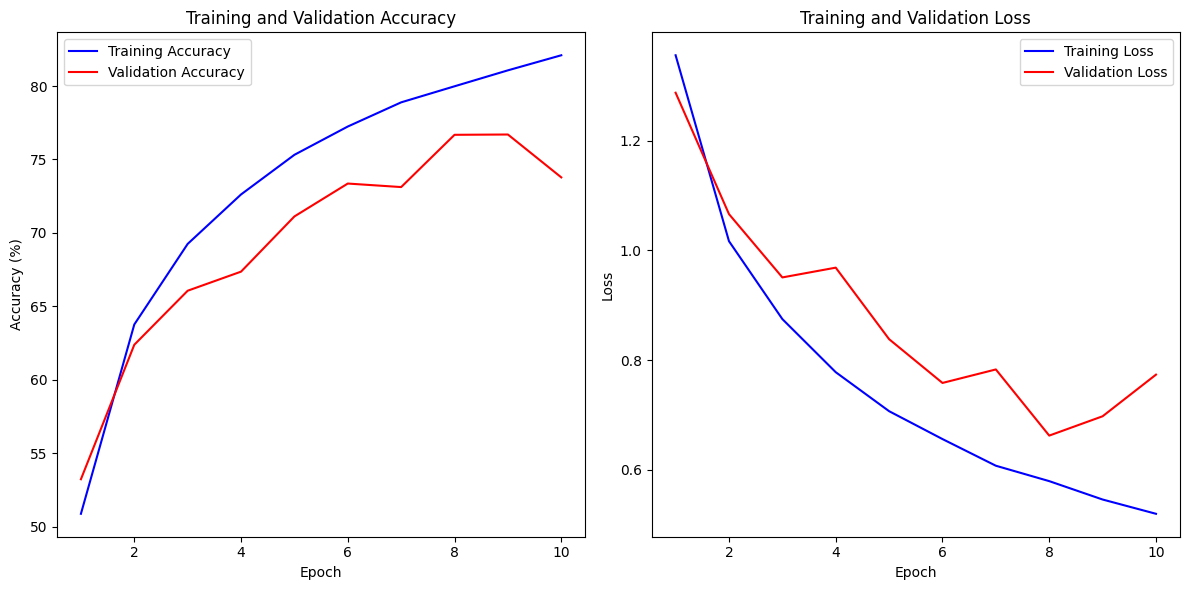

In [ ]:
train_losses, train_accs, val_losses, val_accs, test_acc = train_model(model1, train_loader, val_loader, test_loader, optimizer_Adam, criterion, num_epochs, device)

##SGD

In [ ]:
import matplotlib.pyplot as plt
model2 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(model2.parameters(), lr=learning_rate)

def train_model(model2, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs, device):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        model2.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model2(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

        # Update learning rate
        scheduler.step()

        # Evaluation
        model2.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss = 0.0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model2(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Test evaluation
    model2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_accs.append(test_acc)
    print(f"Final Test Accuracy: {test_acc:.2f}%")

    # Plot training and validation accuracy and loss
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accs, val_losses, val_accs, test_acc

Epoch [1/10], Train Loss: 2.1696, Train Acc: 22.55%
Validation Loss: 2.0699, Validation Accuracy: 26.76%
Epoch [2/10], Train Loss: 2.0225, Train Acc: 28.67%
Validation Loss: 1.9689, Validation Accuracy: 30.16%
Epoch [3/10], Train Loss: 1.9449, Train Acc: 30.90%
Validation Loss: 1.9114, Validation Accuracy: 32.30%
Epoch [4/10], Train Loss: 1.8892, Train Acc: 32.54%
Validation Loss: 1.8560, Validation Accuracy: 34.08%
Epoch [5/10], Train Loss: 1.8431, Train Acc: 33.86%
Validation Loss: 1.8131, Validation Accuracy: 35.92%
Epoch [6/10], Train Loss: 1.8014, Train Acc: 35.26%
Validation Loss: 1.7723, Validation Accuracy: 37.12%
Epoch [7/10], Train Loss: 1.7590, Train Acc: 37.06%
Validation Loss: 1.7369, Validation Accuracy: 37.94%
Epoch [8/10], Train Loss: 1.7229, Train Acc: 38.26%
Validation Loss: 1.7072, Validation Accuracy: 39.10%
Epoch [9/10], Train Loss: 1.6895, Train Acc: 39.11%
Validation Loss: 1.6731, Validation Accuracy: 40.68%
Epoch [10/10], Train Loss: 1.6581, Train Acc: 40.34%
Va

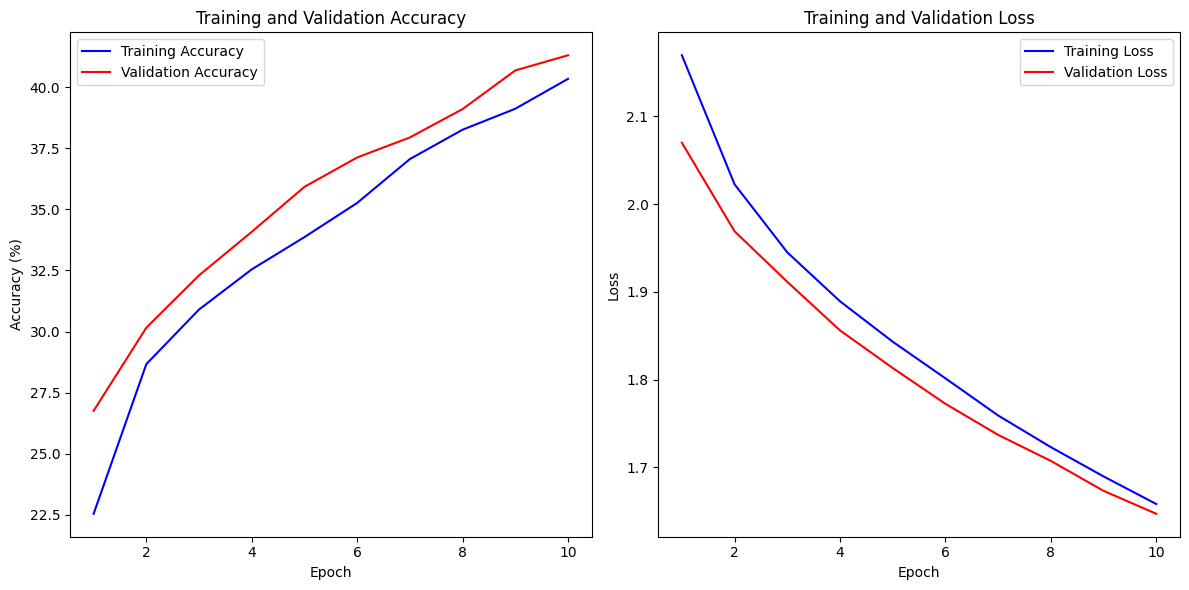

In [ ]:
train_losses, train_accs, val_losses, val_accs, test_acc = train_model(model2, train_loader, val_loader, test_loader, optimizer_SGD, criterion, num_epochs, device)

##RMS

In [ ]:
import matplotlib.pyplot as plt
model3 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_RMS = optim.RMSprop(model3.parameters(), lr=learning_rate)

def train_model(model3, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs, device):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        model3.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model3(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

        # Update learning rate
        scheduler.step()

        # Evaluation
        model3.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss = 0.0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model3(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Test evaluation
    model3.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_accs.append(test_acc)
    print(f"Final Test Accuracy: {test_acc:.2f}%")

    # Plot training and validation accuracy and loss
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accs, val_losses, val_accs, test_acc

Epoch [1/10], Train Loss: 1.4191, Train Acc: 48.15%
Validation Loss: 1.5370, Validation Accuracy: 46.78%
Epoch [2/10], Train Loss: 1.0500, Train Acc: 62.30%
Validation Loss: 1.1796, Validation Accuracy: 58.48%
Epoch [3/10], Train Loss: 0.9159, Train Acc: 67.56%
Validation Loss: 1.0430, Validation Accuracy: 63.32%
Epoch [4/10], Train Loss: 0.8237, Train Acc: 70.77%
Validation Loss: 1.0356, Validation Accuracy: 65.16%
Epoch [5/10], Train Loss: 0.7449, Train Acc: 73.75%
Validation Loss: 0.9448, Validation Accuracy: 68.16%
Epoch [6/10], Train Loss: 0.6919, Train Acc: 75.74%
Validation Loss: 0.9191, Validation Accuracy: 68.94%
Epoch [7/10], Train Loss: 0.6426, Train Acc: 77.69%
Validation Loss: 0.9095, Validation Accuracy: 68.90%
Epoch [8/10], Train Loss: 0.6031, Train Acc: 78.82%
Validation Loss: 1.0753, Validation Accuracy: 63.66%
Epoch [9/10], Train Loss: 0.5724, Train Acc: 80.12%
Validation Loss: 0.8847, Validation Accuracy: 69.62%
Epoch [10/10], Train Loss: 0.5473, Train Acc: 81.03%
Va

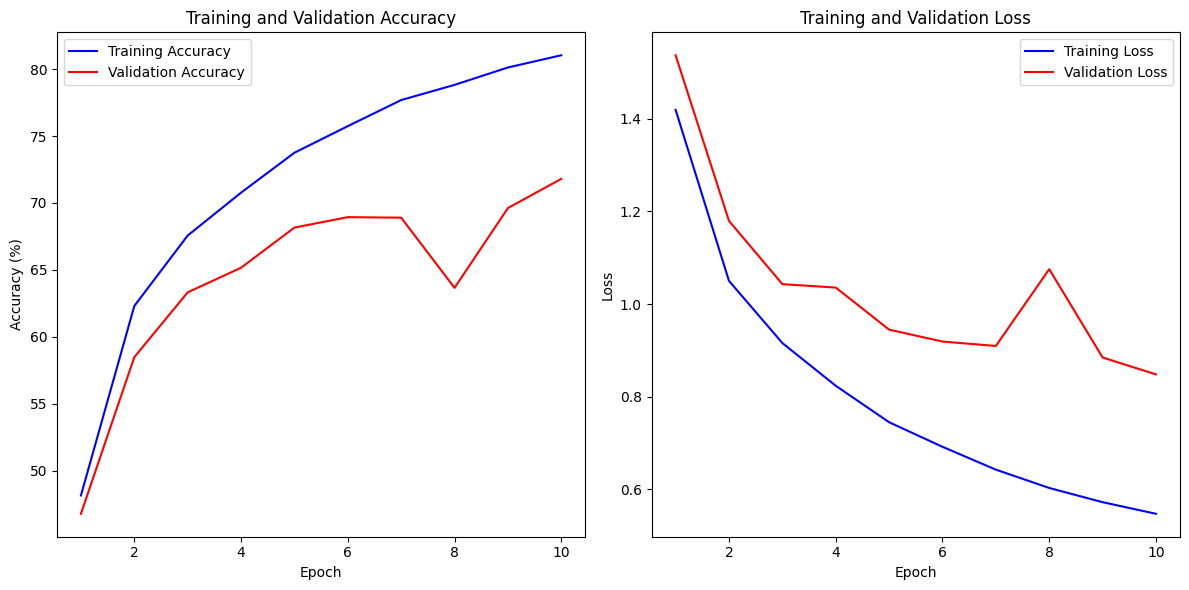

In [ ]:
train_losses, train_accs, val_losses, val_accs, test_acc = train_model(model3, train_loader, val_loader, test_loader, optimizer_RMS, criterion, num_epochs, device)

#4.Use Learning Rate Scheduling

Epoch [1/10], Train Loss: 0.5074, Train Acc: 82.44%
Validation Loss: 0.6450, Validation Accuracy: 77.92%
Epoch [2/10], Train Loss: 0.4774, Train Acc: 83.62%
Validation Loss: 0.5642, Validation Accuracy: 81.06%
Epoch [3/10], Train Loss: 0.4493, Train Acc: 84.53%
Validation Loss: 0.5979, Validation Accuracy: 79.82%
Epoch [4/10], Train Loss: 0.4176, Train Acc: 85.66%
Validation Loss: 0.5894, Validation Accuracy: 79.64%
Epoch [5/10], Train Loss: 0.3874, Train Acc: 86.69%
Validation Loss: 0.5349, Validation Accuracy: 81.50%
Epoch [6/10], Train Loss: 0.3529, Train Acc: 87.86%
Validation Loss: 0.4859, Validation Accuracy: 83.20%
Epoch [7/10], Train Loss: 0.3242, Train Acc: 88.90%
Validation Loss: 0.4761, Validation Accuracy: 83.88%
Epoch [8/10], Train Loss: 0.2990, Train Acc: 89.88%
Validation Loss: 0.4363, Validation Accuracy: 84.98%
Epoch [9/10], Train Loss: 0.2785, Train Acc: 90.65%
Validation Loss: 0.4220, Validation Accuracy: 85.60%
Epoch [10/10], Train Loss: 0.2659, Train Acc: 91.05%
Va

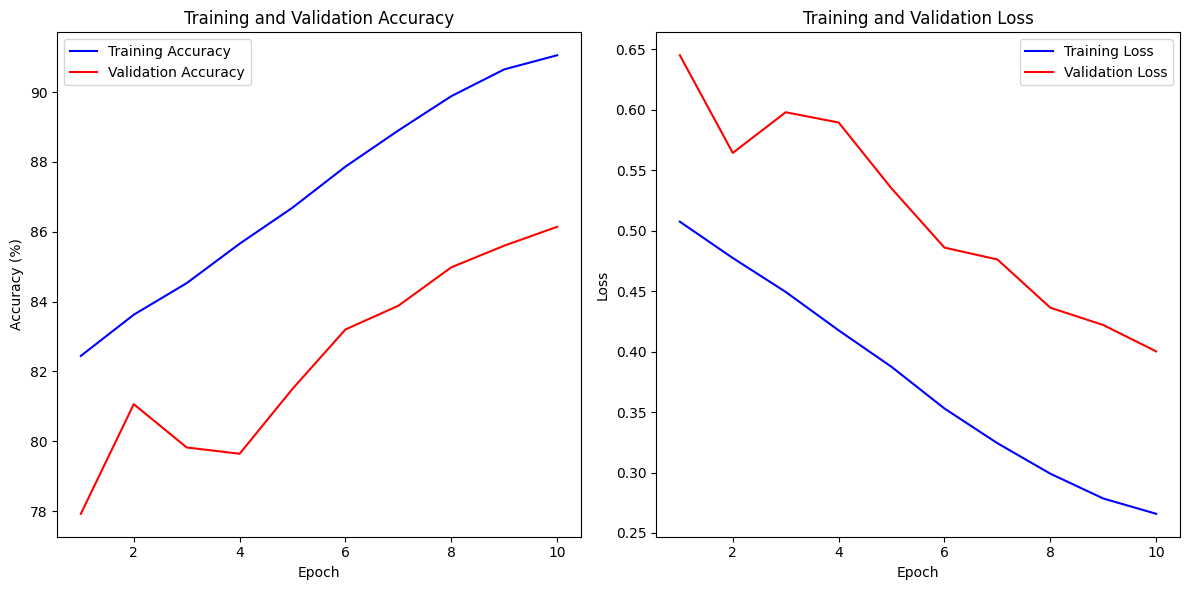

In [ ]:
# Create the optimizer with Cosine Annealing LR scheduler
optimizer_Adam = optim.Adam(model1.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_Adam, T_max=num_epochs)

train_losses, train_accs, val_losses, val_accs, test_acc = train_model(model1, train_loader, val_loader, test_loader, optimizer_Adam, criterion, num_epochs, device)

#5.Apply Regularization Techniques



Epoch [1/10], Train Loss: 0.4021, Train Acc: 86.10%
Validation Loss: 0.5414, Validation Accuracy: 81.90%
Epoch [2/10], Train Loss: 0.3933, Train Acc: 86.34%
Validation Loss: 0.6551, Validation Accuracy: 79.10%
Epoch [3/10], Train Loss: 0.3826, Train Acc: 86.66%
Validation Loss: 0.6960, Validation Accuracy: 78.06%
Epoch [4/10], Train Loss: 0.3552, Train Acc: 87.64%
Validation Loss: 0.5702, Validation Accuracy: 81.44%
Epoch [5/10], Train Loss: 0.3292, Train Acc: 88.76%
Validation Loss: 0.4684, Validation Accuracy: 84.26%
Epoch [6/10], Train Loss: 0.3047, Train Acc: 89.41%
Validation Loss: 0.5295, Validation Accuracy: 82.48%
Epoch [7/10], Train Loss: 0.2687, Train Acc: 90.86%
Validation Loss: 0.4218, Validation Accuracy: 85.54%
Epoch [8/10], Train Loss: 0.2441, Train Acc: 91.74%
Validation Loss: 0.4223, Validation Accuracy: 85.72%
Epoch [9/10], Train Loss: 0.2215, Train Acc: 92.50%
Validation Loss: 0.3855, Validation Accuracy: 87.00%
Epoch [10/10], Train Loss: 0.2109, Train Acc: 93.02%
Va

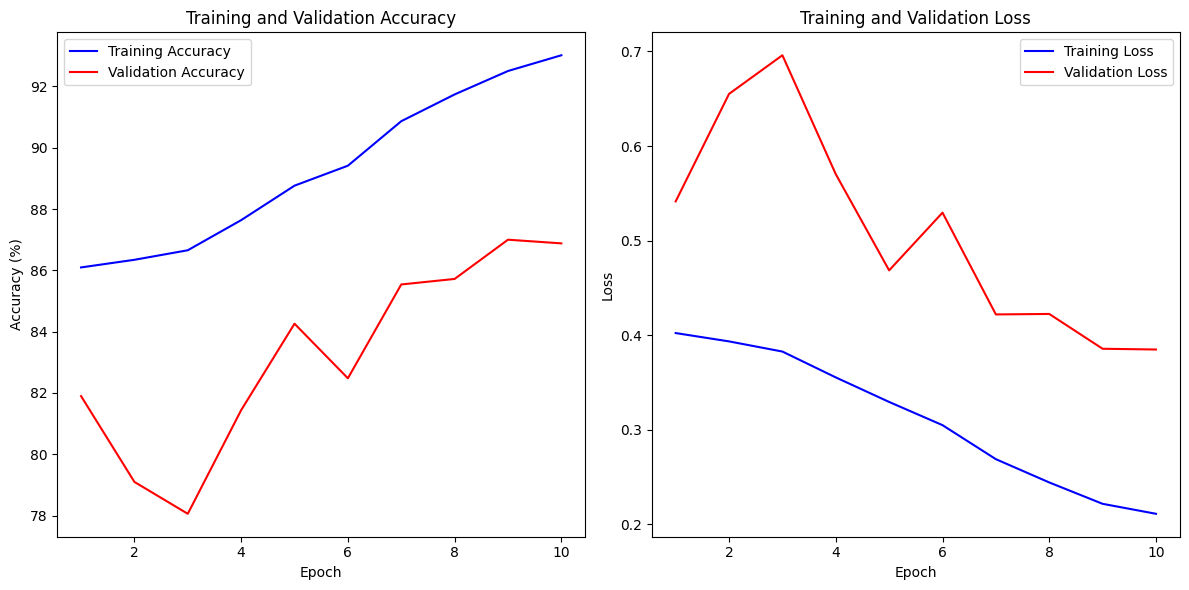

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler # Import the lr_scheduler module

# Create the optimizer with Cosine Annealing LR scheduler
optimizer_Adam = optim.Adam(model1.parameters(), lr=learning_rate,weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_Adam, T_max=num_epochs)
train_losses, train_accs, val_losses, val_accs, test_acc = train_model(model1, train_loader, val_loader, test_loader, optimizer_Adam, criterion, num_epochs, device)

#6.Perform Extensive Hyperparameter Tuning

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


[I 2024-07-18 20:36:17,031] A new study created in memory with name: no-name-d74cd7e9-0208-4492-9949-5fe9598a3e56


Epoch [1/5], Train Loss: 1.9644, Train Acc: 30.18%
Validation Loss: 1.7931, Validation Accuracy: 38.00%
Epoch [2/5], Train Loss: 1.7153, Train Acc: 40.39%
Validation Loss: 1.6424, Validation Accuracy: 44.20%
Epoch [3/5], Train Loss: 1.5908, Train Acc: 45.00%
Validation Loss: 1.5367, Validation Accuracy: 48.48%
Epoch [4/5], Train Loss: 1.4958, Train Acc: 48.46%
Validation Loss: 1.4539, Validation Accuracy: 50.56%
Epoch [5/5], Train Loss: 1.4258, Train Acc: 50.88%
Validation Loss: 1.3882, Validation Accuracy: 52.72%
Final Test Accuracy: 52.11%


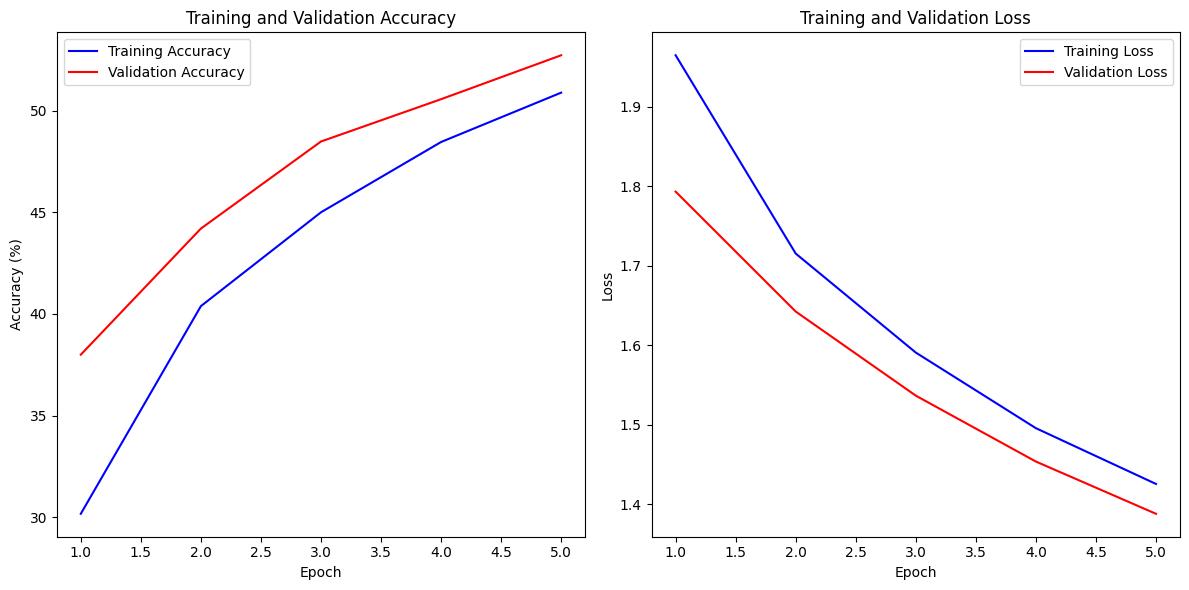

[I 2024-07-18 20:39:21,661] Trial 0 finished with value: 52.72 and parameters: {'learning_rate': 1.2125365823602364e-05, 'weight_decay': 5.323316032011788e-05}. Best is trial 0 with value: 52.72.


Epoch [1/5], Train Loss: 1.3757, Train Acc: 49.70%
Validation Loss: 1.3092, Validation Accuracy: 52.84%
Epoch [2/5], Train Loss: 1.0455, Train Acc: 62.47%
Validation Loss: 1.0913, Validation Accuracy: 61.20%
Epoch [3/5], Train Loss: 0.9131, Train Acc: 67.72%
Validation Loss: 1.0706, Validation Accuracy: 62.12%
Epoch [4/5], Train Loss: 0.8049, Train Acc: 71.71%
Validation Loss: 1.0892, Validation Accuracy: 63.12%
Epoch [5/5], Train Loss: 0.7396, Train Acc: 74.11%
Validation Loss: 0.8519, Validation Accuracy: 70.44%
Final Test Accuracy: 70.17%


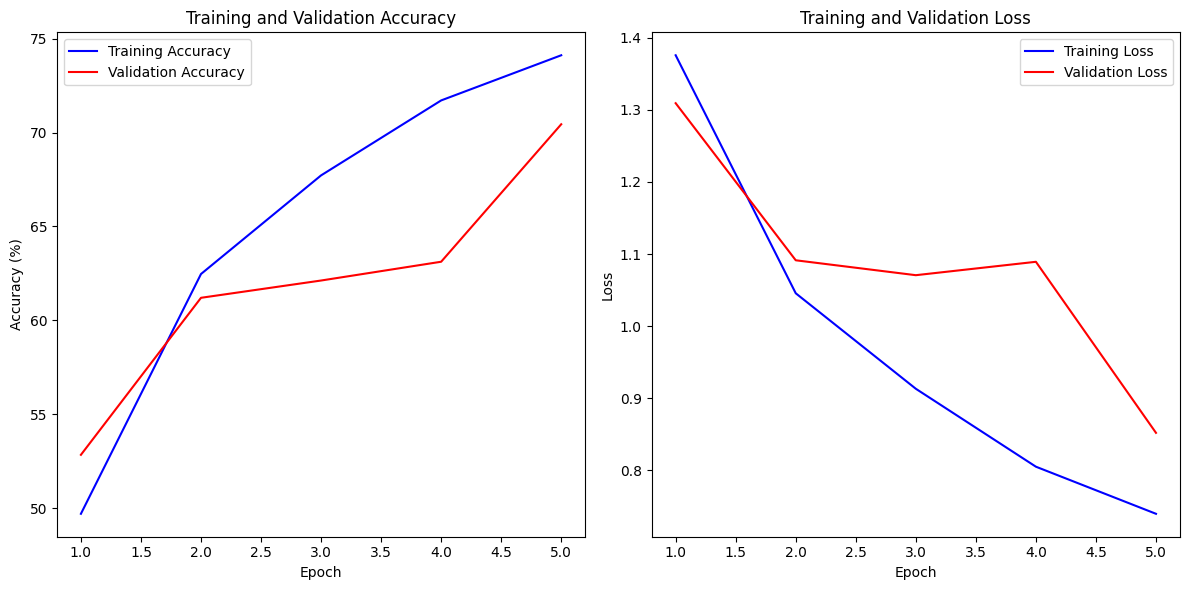

[I 2024-07-18 20:42:27,181] Trial 1 finished with value: 70.44 and parameters: {'learning_rate': 0.0026308155346286143, 'weight_decay': 9.802370332762489e-05}. Best is trial 1 with value: 70.44.


Epoch [1/5], Train Loss: 0.5761, Train Acc: 80.21%
Validation Loss: 0.5819, Validation Accuracy: 79.82%
Epoch [2/5], Train Loss: 0.5370, Train Acc: 81.54%
Validation Loss: 0.5808, Validation Accuracy: 79.38%
Epoch [3/5], Train Loss: 0.5147, Train Acc: 82.26%
Validation Loss: 0.5878, Validation Accuracy: 79.60%
Epoch [4/5], Train Loss: 0.4994, Train Acc: 82.74%
Validation Loss: 0.5546, Validation Accuracy: 80.54%
Epoch [5/5], Train Loss: 0.4778, Train Acc: 83.66%
Validation Loss: 0.5884, Validation Accuracy: 79.34%
Final Test Accuracy: 79.90%


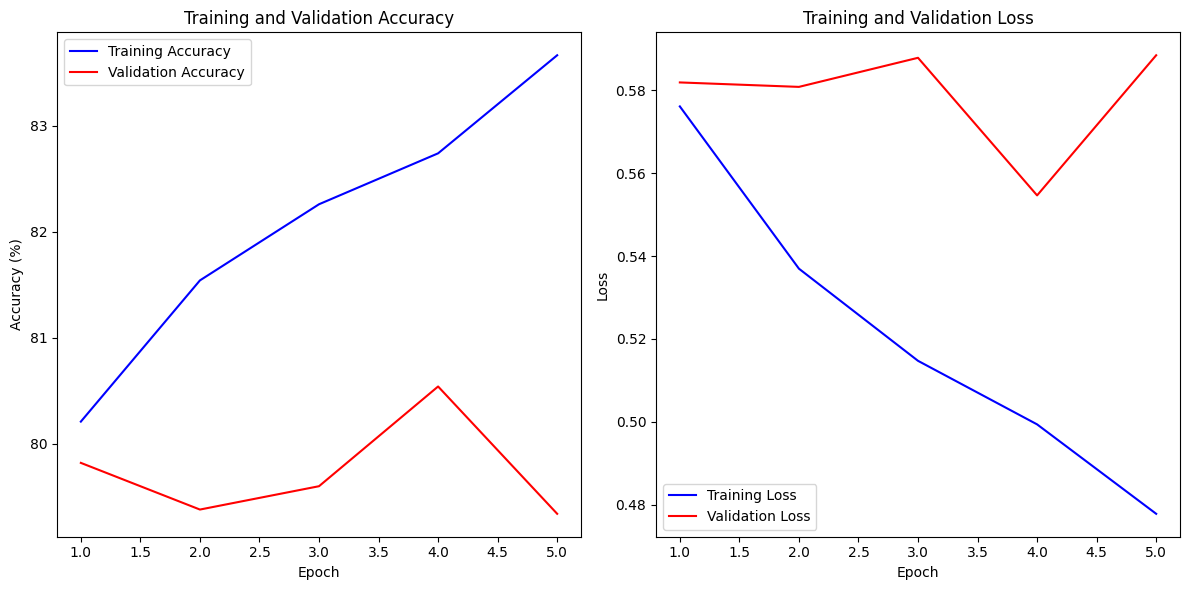

[I 2024-07-18 20:45:32,181] Trial 2 finished with value: 79.34 and parameters: {'learning_rate': 0.0005602576616551199, 'weight_decay': 0.00028103191207272903}. Best is trial 2 with value: 79.34.


Epoch [1/5], Train Loss: 0.5427, Train Acc: 81.42%
Validation Loss: 0.6912, Validation Accuracy: 76.20%
Epoch [2/5], Train Loss: 0.5924, Train Acc: 79.91%
Validation Loss: 0.6949, Validation Accuracy: 76.08%
Epoch [3/5], Train Loss: 0.6230, Train Acc: 79.15%
Validation Loss: 0.8198, Validation Accuracy: 70.66%
Epoch [4/5], Train Loss: 0.6225, Train Acc: 79.21%
Validation Loss: 0.6935, Validation Accuracy: 76.30%
Epoch [5/5], Train Loss: 0.6179, Train Acc: 79.52%
Validation Loss: 0.7484, Validation Accuracy: 74.30%
Final Test Accuracy: 75.06%


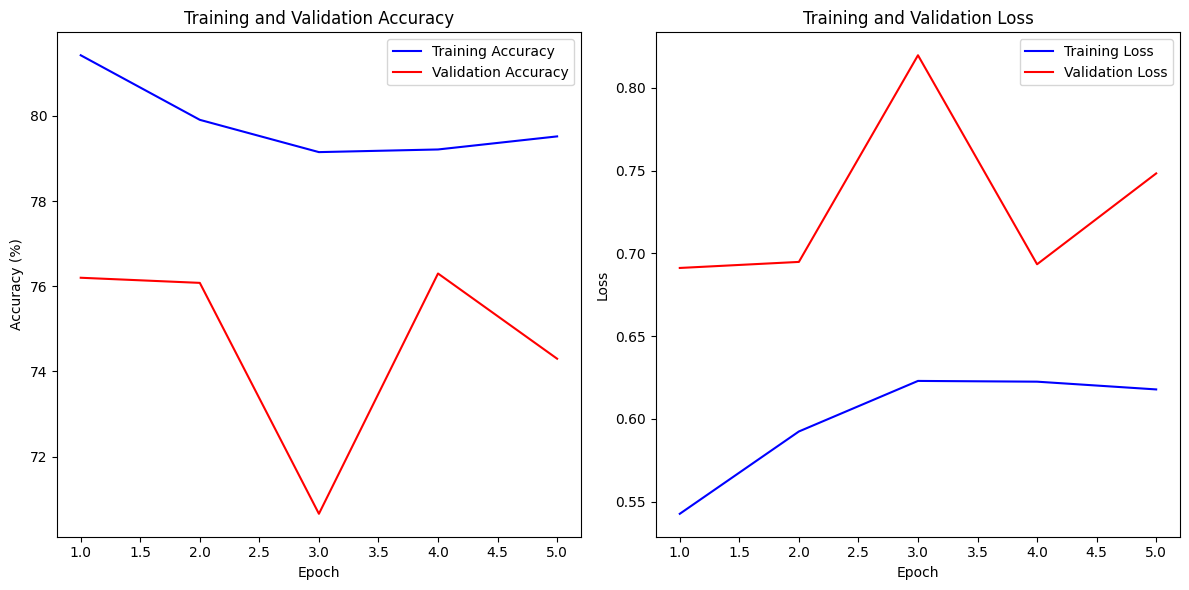

[I 2024-07-18 20:48:36,622] Trial 3 finished with value: 74.3 and parameters: {'learning_rate': 0.0009080466448236874, 'weight_decay': 0.0032216294120142766}. Best is trial 2 with value: 79.34.


Epoch [1/5], Train Loss: 1.0978, Train Acc: 61.44%
Validation Loss: 1.6230, Validation Accuracy: 48.02%
Epoch [2/5], Train Loss: 0.8443, Train Acc: 70.29%
Validation Loss: 1.1216, Validation Accuracy: 62.90%
Epoch [3/5], Train Loss: 0.7696, Train Acc: 73.11%
Validation Loss: 1.0648, Validation Accuracy: 64.14%
Epoch [4/5], Train Loss: 0.7293, Train Acc: 74.57%
Validation Loss: 0.9434, Validation Accuracy: 67.14%
Epoch [5/5], Train Loss: 0.7065, Train Acc: 75.38%
Validation Loss: 0.8002, Validation Accuracy: 72.38%
Final Test Accuracy: 71.67%


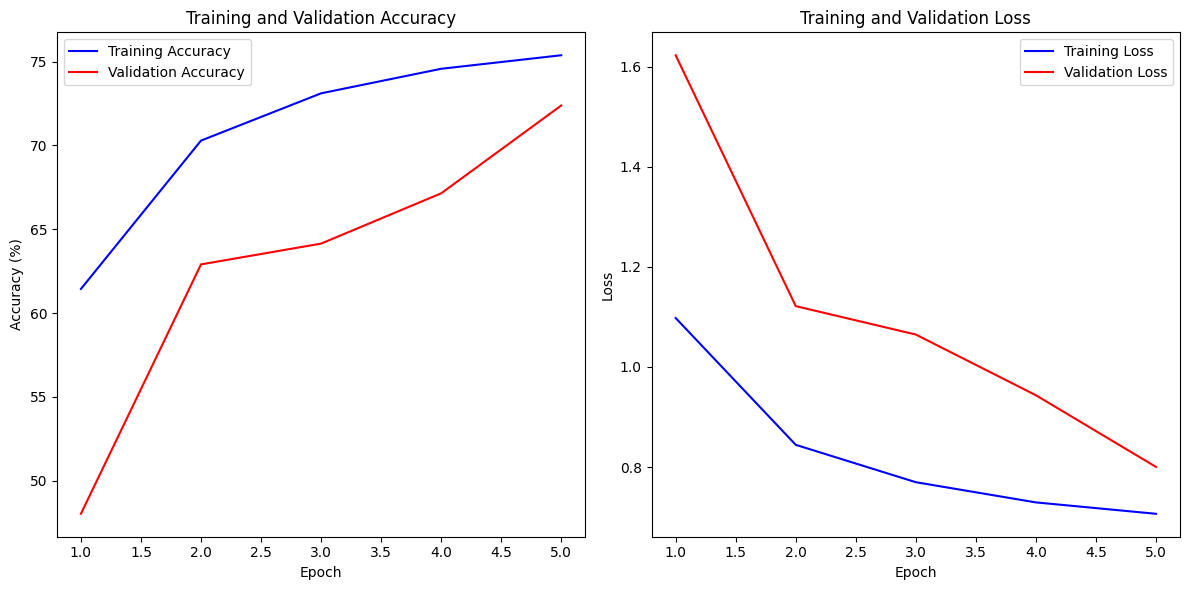

[I 2024-07-18 20:51:39,076] Trial 4 finished with value: 72.38 and parameters: {'learning_rate': 0.008644972375555345, 'weight_decay': 0.000175242971330209}. Best is trial 2 with value: 79.34.


Epoch [1/5], Train Loss: 0.5868, Train Acc: 80.14%
Validation Loss: 0.5928, Validation Accuracy: 80.38%
Epoch [2/5], Train Loss: 0.5430, Train Acc: 81.65%
Validation Loss: 0.5658, Validation Accuracy: 81.04%
Epoch [3/5], Train Loss: 0.5278, Train Acc: 82.15%
Validation Loss: 0.5548, Validation Accuracy: 81.36%
Epoch [4/5], Train Loss: 0.5183, Train Acc: 82.64%
Validation Loss: 0.5557, Validation Accuracy: 81.80%
Epoch [5/5], Train Loss: 0.5136, Train Acc: 82.73%
Validation Loss: 0.5513, Validation Accuracy: 81.84%
Final Test Accuracy: 81.75%


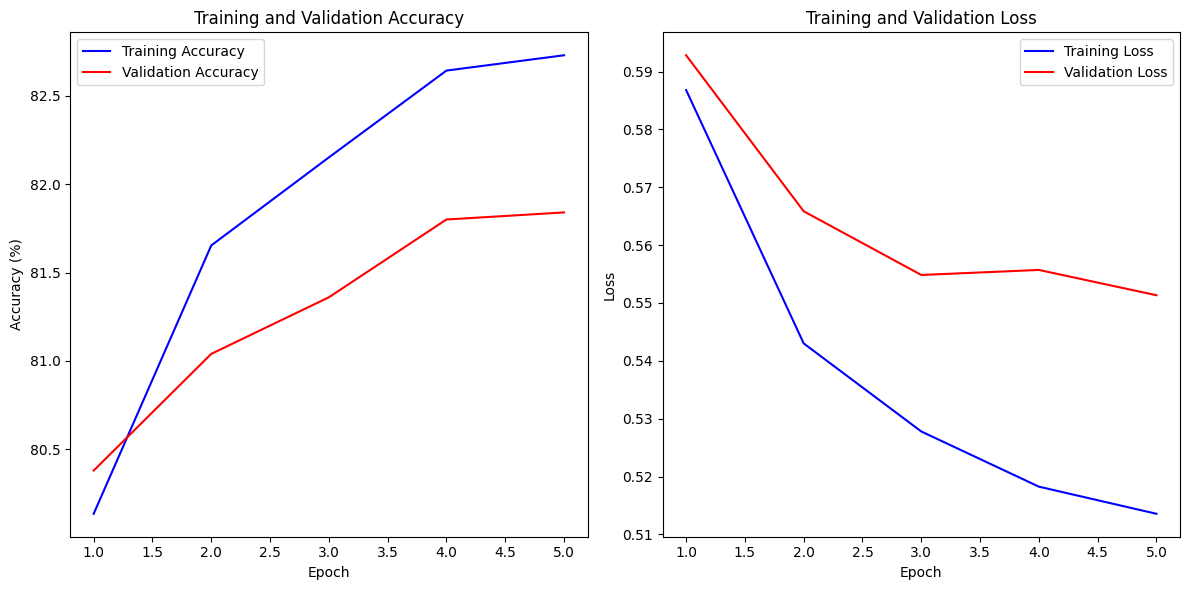

[I 2024-07-18 20:54:43,196] Trial 5 finished with value: 81.84 and parameters: {'learning_rate': 8.625440195087087e-05, 'weight_decay': 0.0019375847512483032}. Best is trial 5 with value: 81.84.


Epoch [1/5], Train Loss: 0.5078, Train Acc: 82.90%
Validation Loss: 0.5389, Validation Accuracy: 82.12%
Epoch [2/5], Train Loss: 0.5021, Train Acc: 83.08%
Validation Loss: 0.5382, Validation Accuracy: 82.42%
Epoch [3/5], Train Loss: 0.4976, Train Acc: 83.32%
Validation Loss: 0.5338, Validation Accuracy: 82.48%
Epoch [4/5], Train Loss: 0.4940, Train Acc: 83.43%
Validation Loss: 0.5284, Validation Accuracy: 82.60%
Epoch [5/5], Train Loss: 0.4887, Train Acc: 83.44%
Validation Loss: 0.5286, Validation Accuracy: 82.66%
Final Test Accuracy: 82.12%


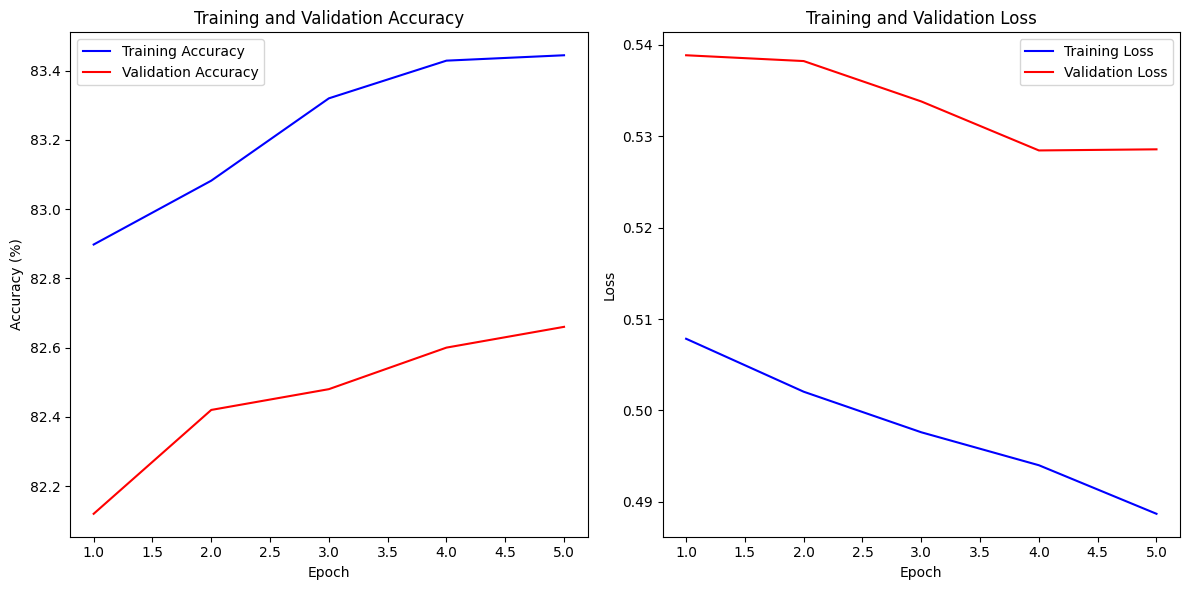

[I 2024-07-18 20:57:46,533] Trial 6 finished with value: 82.66 and parameters: {'learning_rate': 3.864755955769832e-05, 'weight_decay': 1.2215275388633026e-05}. Best is trial 6 with value: 82.66.


Epoch [1/5], Train Loss: 0.4969, Train Acc: 83.09%
Validation Loss: 0.5346, Validation Accuracy: 81.82%
Epoch [2/5], Train Loss: 0.4715, Train Acc: 83.88%
Validation Loss: 0.5298, Validation Accuracy: 81.72%
Epoch [3/5], Train Loss: 0.4500, Train Acc: 84.54%
Validation Loss: 0.4955, Validation Accuracy: 83.46%
Epoch [4/5], Train Loss: 0.4369, Train Acc: 85.12%
Validation Loss: 0.4907, Validation Accuracy: 83.46%
Epoch [5/5], Train Loss: 0.4192, Train Acc: 85.59%
Validation Loss: 0.4980, Validation Accuracy: 83.08%
Final Test Accuracy: 83.11%


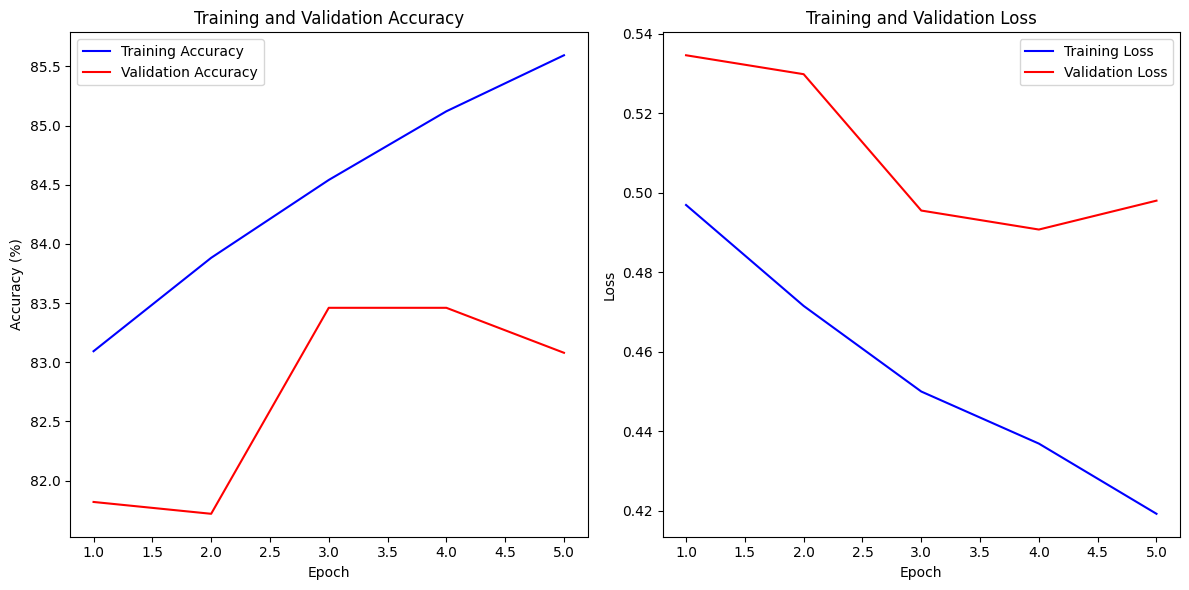

[I 2024-07-18 21:00:50,741] Trial 7 finished with value: 83.08 and parameters: {'learning_rate': 0.0009255915661603655, 'weight_decay': 4.7451842131696344e-05}. Best is trial 7 with value: 83.08.


Epoch [1/5], Train Loss: 0.4207, Train Acc: 85.64%
Validation Loss: 0.4960, Validation Accuracy: 83.24%
Epoch [2/5], Train Loss: 0.4059, Train Acc: 85.91%
Validation Loss: 0.4926, Validation Accuracy: 83.46%
Epoch [3/5], Train Loss: 0.3956, Train Acc: 86.45%
Validation Loss: 0.5089, Validation Accuracy: 83.56%
Epoch [4/5], Train Loss: 0.3888, Train Acc: 86.58%
Validation Loss: 0.4924, Validation Accuracy: 83.56%
Epoch [5/5], Train Loss: 0.3719, Train Acc: 87.22%
Validation Loss: 0.4761, Validation Accuracy: 84.28%
Final Test Accuracy: 83.97%


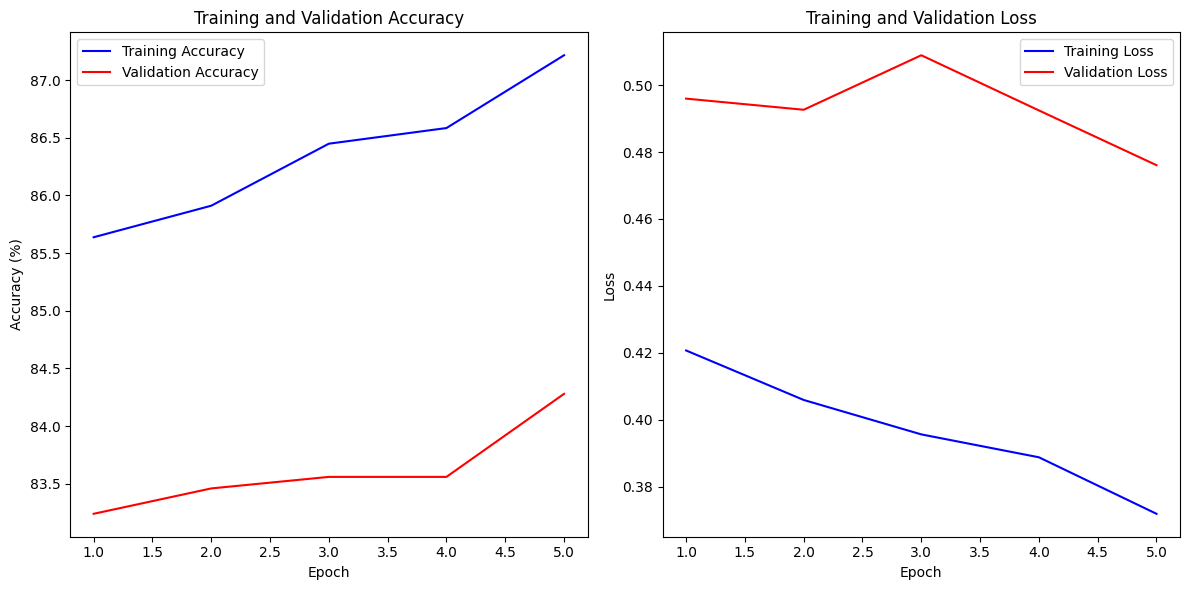

[I 2024-07-18 21:03:54,004] Trial 8 finished with value: 84.28 and parameters: {'learning_rate': 0.0012254450316902925, 'weight_decay': 2.650619471812329e-05}. Best is trial 8 with value: 84.28.


Epoch [1/5], Train Loss: 0.6841, Train Acc: 76.32%
Validation Loss: 1.2688, Validation Accuracy: 56.82%
Epoch [2/5], Train Loss: 0.7622, Train Acc: 73.59%
Validation Loss: 1.3099, Validation Accuracy: 61.22%
Epoch [3/5], Train Loss: 0.7816, Train Acc: 73.06%
Validation Loss: 1.0523, Validation Accuracy: 64.74%
Epoch [4/5], Train Loss: 0.7953, Train Acc: 72.57%
Validation Loss: 0.9845, Validation Accuracy: 65.82%
Epoch [5/5], Train Loss: 0.7881, Train Acc: 73.00%
Validation Loss: 1.1122, Validation Accuracy: 61.46%
Final Test Accuracy: 62.40%


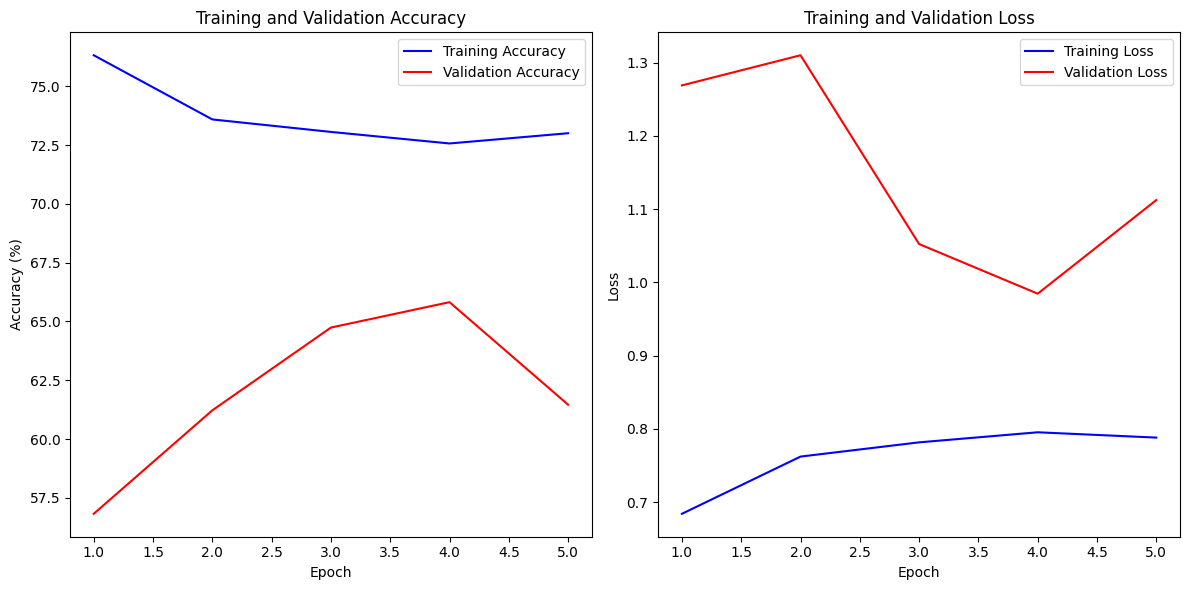

[I 2024-07-18 21:06:55,872] Trial 9 finished with value: 61.46 and parameters: {'learning_rate': 0.006767842381198305, 'weight_decay': 0.0015364650215005903}. Best is trial 8 with value: 84.28.


Best hyperparameters:  {'learning_rate': 0.0012254450316902925, 'weight_decay': 2.650619471812329e-05}
Best validation accuracy:  84.28


In [ ]:
import optuna
model4 = CNN().to(device)

# Assuming these variables are defined in your environment
criterion = nn.CrossEntropyLoss()
num_epochs = 5

def objective(trial):
    # Define hyperparameters to be tuned
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Create optimizer
    optimizer_Adam = optim.Adam(model4.parameters(), lr=learning_rate,weight_decay=weight_decay)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer_Adam, T_max=num_epochs)


    # Train the model with the specified hyperparameters
    train_losses, train_accs, val_losses, val_accs, test_acc = train_model(model4, train_loader, val_loader, test_loader, optimizer_Adam, criterion, num_epochs, device)

    # Return the validation accuracy as the objective value
    return val_accs[-1]

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize") # want to maximize the validation accuracy
study.optimize(objective, n_trials=10)

# Print the best hyperparameters and the corresponding validation accuracy
print("Best hyperparameters: ", study.best_params)
print("Best validation accuracy: ", study.best_value)

In [ ]:
best_params = study.best_params

Epoch [1/5], Train Loss: 0.8987, Train Acc: 68.54%
Validation Loss: 1.0410, Validation Accuracy: 63.02%
Epoch [2/5], Train Loss: 0.7602, Train Acc: 73.32%
Validation Loss: 0.9309, Validation Accuracy: 67.26%
Epoch [3/5], Train Loss: 0.6663, Train Acc: 76.74%
Validation Loss: 0.7442, Validation Accuracy: 74.22%
Epoch [4/5], Train Loss: 0.5832, Train Acc: 79.96%
Validation Loss: 0.6403, Validation Accuracy: 77.94%
Epoch [5/5], Train Loss: 0.5152, Train Acc: 82.53%
Validation Loss: 0.5591, Validation Accuracy: 80.50%
Final Test Accuracy: 80.45%


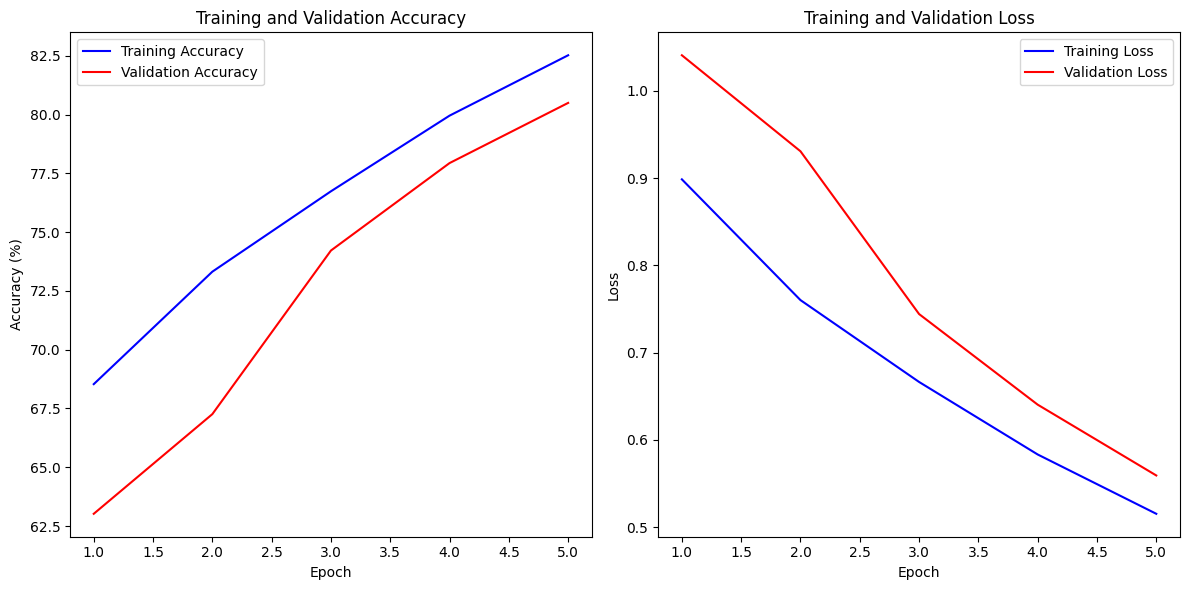

In [ ]:
optimizer_Adam = optim.Adam(model4.parameters(), lr=study.best_params['learning_rate'],weight_decay=study.best_params['weight_decay'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_Adam, T_max=num_epochs)
train_losses, train_accs, val_losses, val_accs, test_acc = train_model(model4, train_loader, val_loader, test_loader, optimizer_Adam, criterion, num_epochs, device)

#7.Ensemble Learning

In [ ]:
import torch.nn.functional as F
import torch.optim as optim

In [ ]:

'''
 ensemble model combines the outputs of the individual models using majority voting to make the final prediction.

'''

# Create the ensemble model
model1 = CNN().to(device)
model2 = CNN().to(device)
model3 = CNN().to(device)

class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, model3):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        output3 = self.model3(x)

        # Combine the outputs using majority voting
        final_output = (output1 + output2 + output3) / 3
        return final_output

ensemble_model = EnsembleModel(model1, model2, model3)
ensemble_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    ensemble_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = ensemble_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

    # Evaluation
    ensemble_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = ensemble_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Test evaluation
ensemble_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = ensemble_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Final Test Accuracy: {test_acc:.2f}%")

Epoch [1/10], Train Loss: 1.3181, Train Acc: 52.01%
Validation Loss: 1.2790, Validation Accuracy: 54.86%
Epoch [2/10], Train Loss: 0.9780, Train Acc: 65.19%
Validation Loss: 1.0120, Validation Accuracy: 64.06%
Epoch [3/10], Train Loss: 0.8325, Train Acc: 70.69%
Validation Loss: 1.0413, Validation Accuracy: 63.68%
Epoch [4/10], Train Loss: 0.7374, Train Acc: 74.07%
Validation Loss: 0.8472, Validation Accuracy: 71.18%
Epoch [5/10], Train Loss: 0.6650, Train Acc: 76.84%
Validation Loss: 0.8150, Validation Accuracy: 72.60%
Epoch [6/10], Train Loss: 0.6153, Train Acc: 78.52%
Validation Loss: 0.6873, Validation Accuracy: 75.68%
Epoch [7/10], Train Loss: 0.5704, Train Acc: 80.31%
Validation Loss: 0.6221, Validation Accuracy: 78.26%
Epoch [8/10], Train Loss: 0.5413, Train Acc: 81.32%
Validation Loss: 0.6344, Validation Accuracy: 77.76%
Epoch [9/10], Train Loss: 0.5110, Train Acc: 82.20%
Validation Loss: 0.5874, Validation Accuracy: 80.22%
Epoch [10/10], Train Loss: 0.4826, Train Acc: 83.35%
Va

#8.Adversarial Training

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

model1 = CNN()
model2 = CNN()
model3 = CNN()

# Move the models to the same device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
model2.to(device)
model3.to(device)

# Define the ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, model3):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3

    def forward(self, x, noise_strength=0.1):
        # Add noise to the input
        noise = noise_strength * torch.randn_like(x)
        x_adv = x + noise

        output1 = self.model1(x_adv)
        output2 = self.model2(x_adv)
        output3 = self.model3(x_adv)

        # Combine the outputs using majority voting or other ensemble methods
        final_output = (output1 + output2 + output3) / 3
        return final_output

ensemble_model = EnsembleModel(model1, model2, model3)
ensemble_model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    ensemble_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass with adversarial noise
        outputs = ensemble_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

    # Evaluation
    ensemble_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = ensemble_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Test evaluation
ensemble_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = ensemble_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Final Test Accuracy: {test_acc:.2f}%")

Epoch [1/10], Train Loss: 1.3528, Train Acc: 50.57%
Validation Loss: 1.2002, Validation Accuracy: 56.30%
Epoch [2/10], Train Loss: 1.0117, Train Acc: 63.97%
Validation Loss: 1.1750, Validation Accuracy: 57.80%
Epoch [3/10], Train Loss: 0.8721, Train Acc: 69.16%
Validation Loss: 0.8937, Validation Accuracy: 68.70%
Epoch [4/10], Train Loss: 0.7718, Train Acc: 72.78%
Validation Loss: 0.8811, Validation Accuracy: 69.10%
Epoch [5/10], Train Loss: 0.6998, Train Acc: 75.58%
Validation Loss: 0.8992, Validation Accuracy: 68.64%
Epoch [6/10], Train Loss: 0.6419, Train Acc: 77.66%
Validation Loss: 0.6782, Validation Accuracy: 76.54%
Epoch [7/10], Train Loss: 0.6038, Train Acc: 79.24%
Validation Loss: 0.7397, Validation Accuracy: 74.90%
Epoch [8/10], Train Loss: 0.5709, Train Acc: 80.29%
Validation Loss: 0.7355, Validation Accuracy: 75.08%
Epoch [9/10], Train Loss: 0.5369, Train Acc: 81.29%
Validation Loss: 0.6662, Validation Accuracy: 77.76%
Epoch [10/10], Train Loss: 0.5106, Train Acc: 82.38%
Va

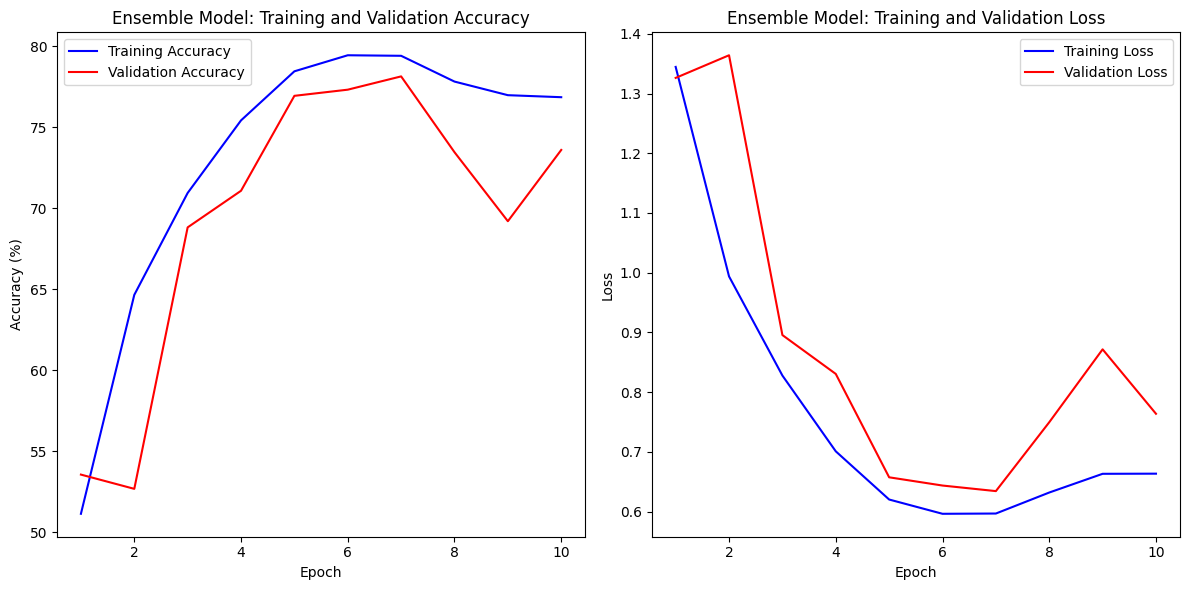

In [ ]:
# Plot training and validation accuracy and loss
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Ensemble Model: Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ensemble Model: Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

#9.Automated Machine Learning (AutoML)


- Some AutoML platforms can also handle automated data preprocessing, such as feature engineering, data augmentation, and handling missing values, which can be helpful for complex datasets like CIFAR-10.

In [ ]:
!pip install pytorch-lightning
import pytorch_lightning as pl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.5 MB/s eta 0:00:00


In [ ]:
!pip install autogluon.tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LightningCIFAR10(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        return {'val_loss': loss}

    def on_validation_epoch_end(self):
        # Compute and log the average validation loss
        # Access the logged validation losses and compute the average
        if isinstance(self.trainer.callback_metrics['val_loss'], torch.Tensor):
            avg_loss = self.trainer.callback_metrics['val_loss'].mean() # Handle the case when val_loss is a single tensor
        else:
            avg_loss = torch.stack([x for x in self.trainer.callback_metrics['val_loss']]).mean()
        self.log('val_loss', avg_loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)
        return {'test_loss': loss}

    def on_test_epoch_end(self):  # Use the on_test_epoch_end hook
        # Access outputs and compute average loss
        pass

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer

# Create the PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=num_epochs)

# Train the model
model = LightningCIFAR10()
trainer.fit(model, train_loader, val_loader)

# Evaluate the model on the test set
trainer.test(model, test_loader)

# Now you can access the test results
test_results = trainer.callback_metrics
avg_test_loss = test_results['test_loss'].item() if isinstance(test_results['test_loss'], torch.Tensor) else torch.stack([x for x in test_results['test_loss']]).mean().item()
print(f"Average Test Loss: {avg_test_loss}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 456    | train
1 | pool  | MaxPool2d | 0      | train
2 | conv2 | Conv2d    | 2.4 K  | train
3 | fc1   | Linear    | 48.1 K | train
4 | fc2   | Linear    | 10.2 K | train
5 | fc3   | Linear    | 850    | train
--------------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.1861985921859741     │
└───────────────────────────┴───────────────────────────┘

Average Test Loss: 1.1861985921859741


#10.Evaluate the Model with Advanced Metrics

- diagonal elements represent the correctly classified samples

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Get predictions on the test set
model1.eval()
y_true = [] # store the true labels and the predicted labels
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

Confusion Matrix:
 [[881  11  21   9   8   2   4   8  37  19]
 [  8 942   0   1   0   2   0   1   6  40]
 [ 38   2 810  42  32  33  30   6   5   2]
 [ 10   4  36 737  33 110  35  14   6  15]
 [ 11   1  30  29 866  21  17  19   5   1]
 [  6   1  21 117  21 804   8  15   2   5]
 [  4   2  20  23   9  11 924   2   3   2]
 [ 15   1  15  23  31  28   4 880   0   3]
 [ 37   9   3   4   1   2   2   1 920  21]
 [ 16  37   4   6   1   0   2   0  16 918]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       0.93      0.94      0.94      1000
           2       0.84      0.81      0.83      1000
           3       0.74      0.74      0.74      1000
           4       0.86      0.87      0.87      1000
           5       0.79      0.80      0.80      1000
           6       0.90      0.92      0.91      1000
           7       0.93      0.88      0.90      1000
           8       0.92      0.92      

- Class 0 has 881 correctly classified samples and 119 misclassified samples.
- Class 1 has 942 correctly classified samples and 58 misclassified samples.
- Class 2 has 810 correctly classified samples and 190 misclassified samples.

- Precision measures : true positive predictions out of all positive predictions.
- Recall measures the proportion of true positive predictions out of all actual positive samples.
- F1-score is the harmonic mean of precision and recall, providing a balanced metric.

- Class 3 has the lowest performance
- correctly classifies 87% of the samples in the test set.

#11.Visualize the Results

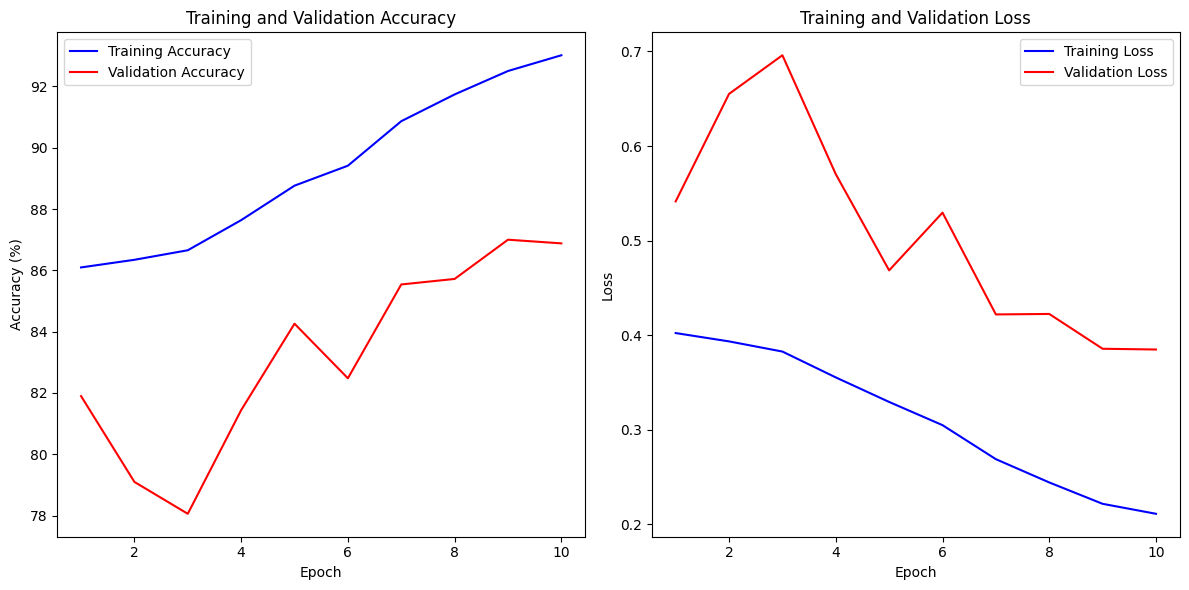

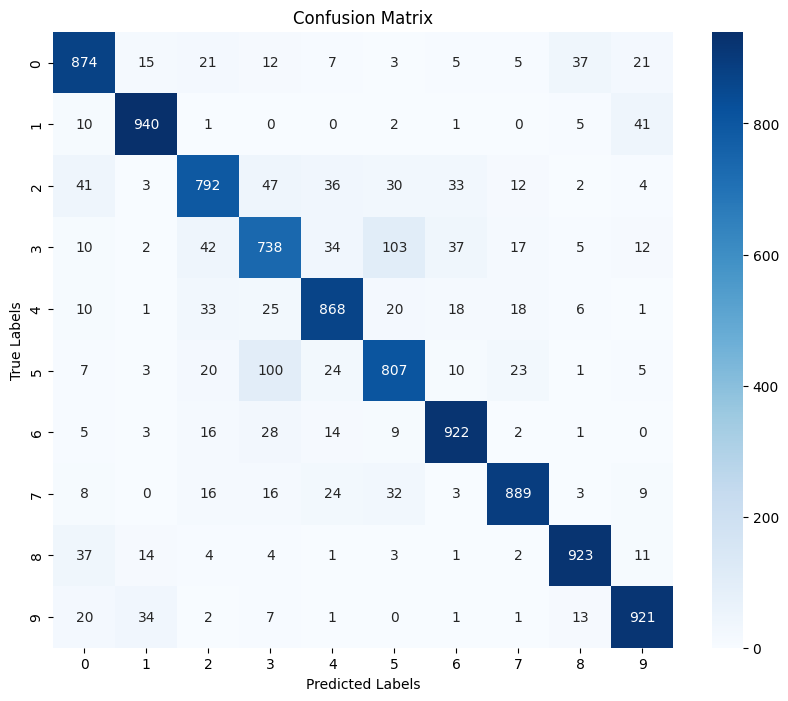

In [ ]:

import seaborn as sns

# Plot training and validation accuracy and loss
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

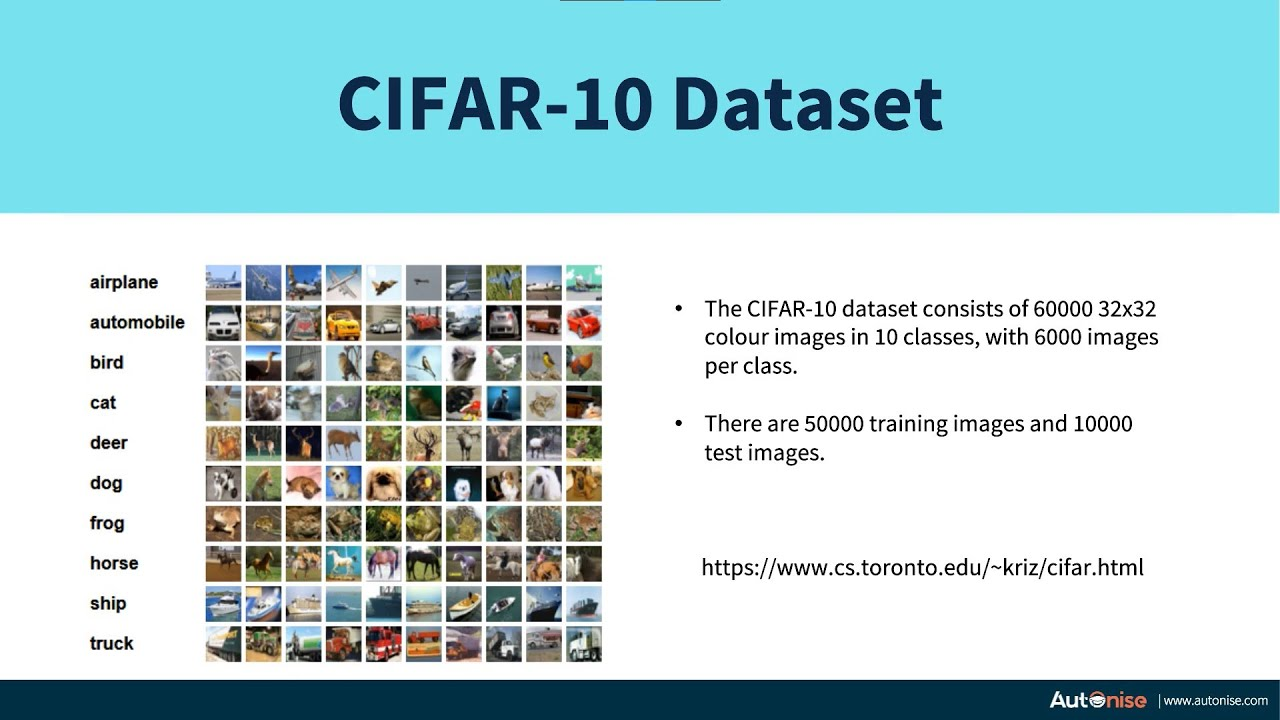